# Computer Vision Project : Enhancing Nucleus Segmentation and 3D Reconstruction Using Super-Resolution


## Group Members:
### Rita Sulaiman – Student ID: 2210765051
### Zeynep Yıldız – Student ID: 2210765033
### Zharasbek Bimagambetov – Student ID: 2210356185


## **Load & Preprocess the Dataset**

### Imports

In [15]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Core libraries
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset


# torchvision
from torchvision import transforms
from torchvision.transforms import functional as TF

# Image quality metrics
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


### Preprocessing and Image Display

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image

# ================================
# CONFIGURATION
# ================================

RAW_ROOT = Path(r"C:\Users\rita\.cache\kagglehub\datasets\ipateam\nuinsseg\versions\5")
OUT_ROOT = Path("data")
SPLITS = ["train", "val", "test"]
TARGET_SIZE = (256, 256)
test_frac = 0.10
val_frac = 0.10
random_seed = 42

# Create output directory structure
for split in SPLITS:
    for sub in ["images", "masks", "distance_maps", "label_masks", "vague_masks"]:
        (OUT_ROOT / split / sub).mkdir(parents=True, exist_ok=True)

print("✅ Directory scaffold created under", OUT_ROOT)

# ================================
# COLLECT VALID TUPLES
# ================================

data_tuples = []
for organ in RAW_ROOT.iterdir():
    if not organ.is_dir():
        continue

    tissue_dir = organ / "tissue images"
    mask_dir   = organ / "mask binary"
    dist_dir   = organ / "distance maps"
    label_dir  = organ / "label masks modify"
    vague_dir  = organ / "vague areas" / "mask binary"

    for d in [tissue_dir, mask_dir, dist_dir, label_dir, vague_dir]:
        if not d.exists():
            print(f"⚠️ Skipping {organ.name}: missing {d}")
            break
    else:
        for img_path in tissue_dir.glob("*.png"):
            stem = img_path.stem
            m1 = mask_dir / f"{stem}.png"
            m2 = dist_dir / f"{stem}.png"
            m3 = label_dir / f"{stem}.tif"
            m4 = vague_dir / f"{stem}.png"
            if m1.exists() and m2.exists() and m3.exists() and m4.exists():
                data_tuples.append((img_path, m1, m2, m3, m4))

print(f"✅ Found {len(data_tuples)} complete data tuples.")

# ================================
# SPLIT DATA
# ================================

train_val, test = train_test_split(data_tuples, test_size=test_frac, random_state=random_seed)
train, val = train_test_split(train_val, test_size=val_frac / (1 - test_frac), random_state=random_seed)
print(f"📊 Split sizes — Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

# ================================
# PROCESS & SAVE RESIZED OUTPUT
# ================================

def process_and_save(split_list, split_name):
    for (img, msk, dist, lbl, vmask) in split_list:
        # Load all
        arr_img  = cv2.imread(str(img))
        arr_msk  = cv2.imread(str(msk),  cv2.IMREAD_GRAYSCALE)
        arr_dist = cv2.imread(str(dist), cv2.IMREAD_GRAYSCALE)
        arr_lbl  = cv2.imread(str(lbl),  cv2.IMREAD_UNCHANGED)
        arr_v    = cv2.imread(str(vmask), cv2.IMREAD_GRAYSCALE)

        # Resize all
        img_r  = cv2.resize(arr_img,  TARGET_SIZE, interpolation=cv2.INTER_CUBIC)
        msk_r  = cv2.resize(arr_msk,  TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
        dist_r = cv2.resize(arr_dist, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
        lbl_r  = cv2.resize(arr_lbl,  TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
        v_r    = cv2.resize(arr_v,    TARGET_SIZE, interpolation=cv2.INTER_NEAREST)

        # Save
        cv2.imwrite(str(OUT_ROOT/split_name/"images"/ img.name),  img_r)
        cv2.imwrite(str(OUT_ROOT/split_name/"masks"/  msk.name),  msk_r)
        cv2.imwrite(str(OUT_ROOT/split_name/"distance_maps"/ dist.name), dist_r)
        cv2.imwrite(str(OUT_ROOT/split_name/"label_masks"/ lbl.name), lbl_r)
        cv2.imwrite(str(OUT_ROOT/split_name/"vague_masks"/ vmask.name),  v_r)

    print(f"✅ {split_name} saved: {len(split_list)} samples")

process_and_save(train, "train")
process_and_save(val,   "val")
process_and_save(test,  "test")

# Confirm counts
for split in SPLITS:
    counts = {sub: len(list((OUT_ROOT/split/sub).glob("*.*"))) for sub in ["images", "masks", "distance_maps", "label_masks", "vague_masks"]}
    print(f"{split} counts: ", counts)


✅ Directory scaffold created under data
✅ Found 665 complete data tuples.
📊 Split sizes — Train: 531, Val: 67, Test: 67
✅ train saved: 531 samples
✅ val saved: 67 samples
✅ test saved: 67 samples
train counts:  {'images': 531, 'masks': 531, 'distance_maps': 531, 'label_masks': 531, 'vague_masks': 531}
val counts:  {'images': 67, 'masks': 67, 'distance_maps': 67, 'label_masks': 67, 'vague_masks': 67}
test counts:  {'images': 67, 'masks': 67, 'distance_maps': 67, 'label_masks': 67, 'vague_masks': 67}


### Downsampling

In [ ]:
##done in safe_downsample.py
## Run using terminal "python safe_downsample.py"

## **Super Resolution**

In [10]:
# ========== CONFIG ==========
downsampled_folder = "downsampled_data/train/images"
original_folder = "data/train/images"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to models
model_paths = {
    "srcnn": "models/srcnn_model.pth",
    "espcn": "models/espcn_x2_256to512.pth",
    "edsr_me": "models/edsr_x2_256to512.pth",
    "edsr": "models/EDSR_x2.pb"
}

# Output dictionary to store results
results = {}


In [11]:
# Define SRCNN
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2)
        )

    def forward(self, x):
        return self.model(x)


# Define SRDFN
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return out + residual  # Skip connection

class EDSR(nn.Module):
    def __init__(self, scale_factor=2, num_channels=64, num_blocks=8):
        super(EDSR, self).__init__()
        self.entry = nn.Conv2d(3, num_channels, kernel_size=3, padding=1)

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_channels) for _ in range(num_blocks)]
        )

        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        self.upsample = nn.Sequential(
            nn.Conv2d(num_channels, 3 * (scale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor)
        )

    def forward(self, x):
        x = self.entry(x)
        res = self.res_blocks(x)
        x = self.conv(res) + x  # Global skip connection
        x = self.upsample(x)
        return x
    

# Define ESPCN
class ESPCN(nn.Module):
    def __init__(self, scale_factor=3):
        super(ESPCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3 * (scale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.pixel_shuffle(x)
        return x



In [12]:
def apply_sr(model_name, img_path):
    image = Image.open(img_path).convert("RGB")
    input_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)

    # Directly load whole model object
    model = torch.load(model_paths[model_name], map_location=device)
    model.eval()

    with torch.no_grad():
        sr = model(input_tensor)

    sr_img = sr.squeeze(0).permute(1, 2, 0).cpu().numpy()
    return np.clip(sr_img, 0, 1)



In [13]:
model_names = ["srcnn", "espcn", "edsr_me"]

for model_name in model_names:
    psnrs = []
    ssims = []

    print(f"🔍 Testing {model_name.upper()}...")

    for filename in tqdm(os.listdir(downsampled_folder)):
        lr_path = os.path.join(downsampled_folder, filename)
        hr_path = os.path.join(original_folder, filename)

        if not os.path.exists(hr_path):
            continue

        # Load images
        lr_img = Image.open(lr_path).convert("RGB")
        hr_img = Image.open(hr_path).convert("RGB")

        # Apply super-resolution
        
        sr_img = apply_sr(model_name, lr_path)

        # Resize to match HR image
        sr_img_resized = np.array(Image.fromarray((sr_img * 255).astype(np.uint8)).resize(hr_img.size)).astype(np.float32) / 255.0
        hr_np = np.array(hr_img).astype(np.float32) / 255.0

        # Metrics
        psnr = peak_signal_noise_ratio(hr_np, sr_img_resized, data_range=1.0)
        ssim = structural_similarity(hr_np, sr_img_resized, channel_axis=-1, data_range=1.0)
        psnrs.append(psnr)
        ssims.append(ssim)

    results[model_name] = {
        "PSNR": np.mean(psnrs),
        "SSIM": np.mean(ssims)
    }

    print(f"✅ {model_name.upper()} — PSNR: {np.mean(psnrs):.2f} | SSIM: {np.mean(ssims):.4f}")


🔍 Testing SRCNN...


  0%|          | 0/531 [00:00<?, ?it/s]C:\Users\rita\AppData\Local\Temp\ipykernel_17528\1356720203.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(mod

✅ SRCNN — PSNR: 31.24 | SSIM: 0.7781
🔍 Testing ESPCN...


100%|██████████| 531/531 [00:09<00:00, 55.50it/s]


✅ ESPCN — PSNR: 33.29 | SSIM: 0.8181
🔍 Testing EDSR_ME...


100%|██████████| 531/531 [00:17<00:00, 29.70it/s]

✅ EDSR_ME — PSNR: 33.66 | SSIM: 0.8311


In [14]:
print("\n📊 Final Comparison:")
for name, metrics in results.items():
    print(f"{name.upper():<10} | PSNR: {metrics['PSNR']:.2f} | SSIM: {metrics['SSIM']:.4f}")



📊 Final Comparison:
SRCNN      | PSNR: 31.24 | SSIM: 0.7781
ESPCN      | PSNR: 33.29 | SSIM: 0.8181
EDSR_ME    | PSNR: 33.66 | SSIM: 0.8311


In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import gc

# Paths
input_root = "downsampled_data"
output_root = "sr_edsr_me_data"
model_path = "models/edsr_x2_256to512.pth"

splits = ["train", "val", "test"]
image_folder = "images"

# Make output folders
for split in splits:
    os.makedirs(os.path.join(output_root, split, image_folder), exist_ok=True)

# Load model
model = torch.load(model_path, map_location="cpu")
model.eval()

# Transforms
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

# Apply SR to all splits
for split in splits:
    print(f"\n⚙️ Processing {split.upper()} split...")
    input_dir = os.path.join(input_root, split, image_folder)
    output_dir = os.path.join(output_root, split, image_folder)

    for fname in tqdm(os.listdir(input_dir)):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        img_path = os.path.join(input_dir, fname)
        img = Image.open(img_path).convert("RGB")
        input_tensor = to_tensor(img).unsqueeze(0)

        with torch.no_grad():
            sr_tensor = model(input_tensor)
            sr_img = sr_tensor.squeeze().permute(1, 2, 0).clamp(0, 1).numpy()

        sr_pil = to_pil(torch.tensor(sr_img).permute(2, 0, 1))
        sr_pil.save(os.path.join(output_dir, fname))

        # 🔄 clear memory
        del input_tensor, sr_tensor, sr_img, sr_pil
        gc.collect()

print("\n✅ Done! Super-resolved images saved to 'sr_edsr_me_data/train|val|test/images'")


C:\Users\rita\AppData\Local\Temp\ipykernel_17528\279304585.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location="cpu")



⚙️ Processing TRAIN split...


100%|██████████| 531/531 [01:54<00:00,  4.63it/s]



⚙️ Processing VAL split...


100%|██████████| 67/67 [00:11<00:00,  5.61it/s]



⚙️ Processing TEST split...


100%|██████████| 67/67 [00:12<00:00,  5.29it/s]


✅ Done! Super-resolved images saved to 'sr_edsr_me_data/train|val|test/images'


## **U-Net Segmentation**

In [81]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Constants
IMG_SIZE = (256, 256)
SR_IMAGE_DIR = "sr_edsr_me_data/train/images"
MASK_DIR     = "downsampled_data/train/masks"

# Initialize
X = []
Y = []

# Iterate through matching filenames
filenames = sorted(os.listdir(SR_IMAGE_DIR))
for fname in tqdm(filenames):
    img_path = os.path.join(SR_IMAGE_DIR, fname)
    mask_path = os.path.join(MASK_DIR, fname)

    if not os.path.exists(mask_path):
        continue  # skip if no matching mask

    # Load image and mask
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype(np.float32) / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMG_SIZE)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    mask = mask.astype(np.float32) / 255.0
    mask = np.expand_dims(mask, axis=-1)

    X.append(img)
    Y.append(mask)

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)
print("X shape:", X.shape)
print("Y shape:", Y.shape)


100%|██████████| 531/531 [00:01<00:00, 371.12it/s]


X shape: (531, 256, 256, 3)
Y shape: (531, 256, 256, 1)


### Prepare PyTorch Dataset & DataLoader


In [82]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.from_numpy(X).permute(0, 3, 1, 2).float()  # (N, 3, 256, 256)
Y_tensor = torch.from_numpy(Y).permute(0, 3, 1, 2).float()  # (N, 1, 256, 256)

dataset = TensorDataset(X_tensor, Y_tensor)
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"✅ Loaded {len(dataset)} samples into train DataLoader.")


✅ Loaded 531 samples into train DataLoader.


### Split into Train/Validation & DataLoaders

In [83]:
from sklearn.model_selection import train_test_split

indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

from torch.utils.data import Subset
train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}")

Train size: 424, Val size: 107


### Define U-Net Model

In [84]:
import torch.nn as nn
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64,128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128,256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256,512))
        self.up2 = nn.ConvTranspose2d(512,256,2,2); self.conv2 = DoubleConv(512,256)
        self.up1 = nn.ConvTranspose2d(256,128,2,2); self.conv1 = DoubleConv(256,128)
        self.up0 = nn.ConvTranspose2d(128,64,2,2);  self.conv0 = DoubleConv(128,64)
        self.outc = nn.Conv2d(64, n_classes, 1)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up2(x4); x = torch.cat([x, x3],1); x = self.conv2(x)
        x = self.up1(x); x = torch.cat([x, x2],1); x = self.conv1(x)
        x = self.up0(x); x = torch.cat([x, x1],1); x = self.conv0(x)
        return self.outc(x)

### Define Loss, Metrics, and Optimizer

In [85]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

def dice_coeff(preds, targets, eps=1e-6):
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    return (2*intersection + eps) / (preds_flat.sum() + targets_flat.sum() + eps)

### Training loop with validation

In [ ]:
epochs = 30
history = {'train_loss':[], 'train_dice':[], 'val_loss':[], 'val_dice':[]}

for epoch in range(1, epochs+1):
    # Train
    model.train()
    train_loss = 0; train_dice = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward(); optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        probs = torch.sigmoid(logits); preds = (probs>0.5).float()
        train_dice += dice_coeff(preds, masks).item() * imgs.size(0)
    train_loss /= len(train_ds)
    train_dice /= len(train_ds)

    # Validate
    model.eval()
    val_loss = 0; val_dice = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            loss = criterion(logits, masks)
            val_loss += loss.item() * imgs.size(0)
            probs = torch.sigmoid(logits); preds = (probs>0.5).float()
            val_dice += dice_coeff(preds, masks).item() * imgs.size(0)
    val_loss /= len(val_ds)
    val_dice /= len(val_ds)

    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)

    print(f"Epoch {epoch}/{epochs}"
          f" - Train Loss: {train_loss:.4f} - Train Dice: {train_dice:.4f}"
          f" - Val Loss: {val_loss:.4f} - Val Dice: {val_dice:.4f}")


Epoch 1/30 - Train Loss: 0.4368 - Train Dice: 0.6133 - Val Loss: 0.3913 - Val Dice: 0.6774
Epoch 2/30 - Train Loss: 0.3325 - Train Dice: 0.6955 - Val Loss: 0.3237 - Val Dice: 0.6990
Epoch 3/30 - Train Loss: 0.2975 - Train Dice: 0.7183 - Val Loss: 0.2767 - Val Dice: 0.7396
Epoch 4/30 - Train Loss: 0.2749 - Train Dice: 0.7352 - Val Loss: 0.2587 - Val Dice: 0.7630
Epoch 5/30 - Train Loss: 0.2575 - Train Dice: 0.7433 - Val Loss: 0.2413 - Val Dice: 0.7588
Epoch 6/30 - Train Loss: 0.2399 - Train Dice: 0.7579 - Val Loss: 0.2197 - Val Dice: 0.7772
Epoch 7/30 - Train Loss: 0.2235 - Train Dice: 0.7735 - Val Loss: 0.2052 - Val Dice: 0.7880
Epoch 8/30 - Train Loss: 0.2134 - Train Dice: 0.7771 - Val Loss: 0.2000 - Val Dice: 0.7919
Epoch 9/30 - Train Loss: 0.2041 - Train Dice: 0.7840 - Val Loss: 0.1992 - Val Dice: 0.8080
Epoch 10/30 - Train Loss: 0.1963 - Train Dice: 0.7880 - Val Loss: 0.1952 - Val Dice: 0.7694
Epoch 11/30 - Train Loss: 0.1877 - Train Dice: 0.7921 - Val Loss: 0.1754 - Val Dice: 0.80

### Plot Loss and Dice Curves

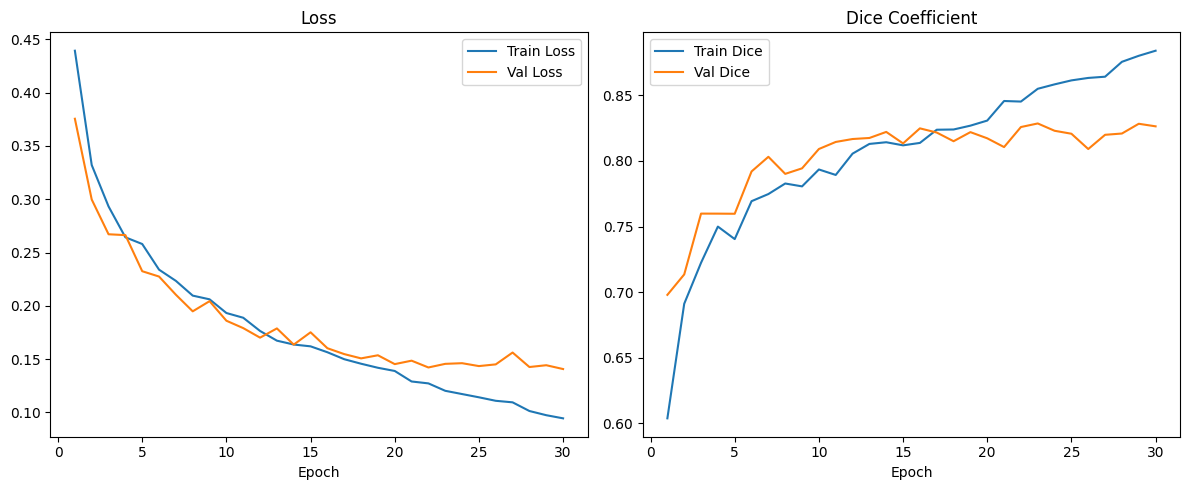

In [ ]:
epochs_range = range(1, epochs+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'],   label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history['train_dice'], label='Train Dice')
plt.plot(epochs_range, history['val_dice'],   label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch'); plt.legend()

plt.tight_layout(); plt.show()

### Predictions Visualization

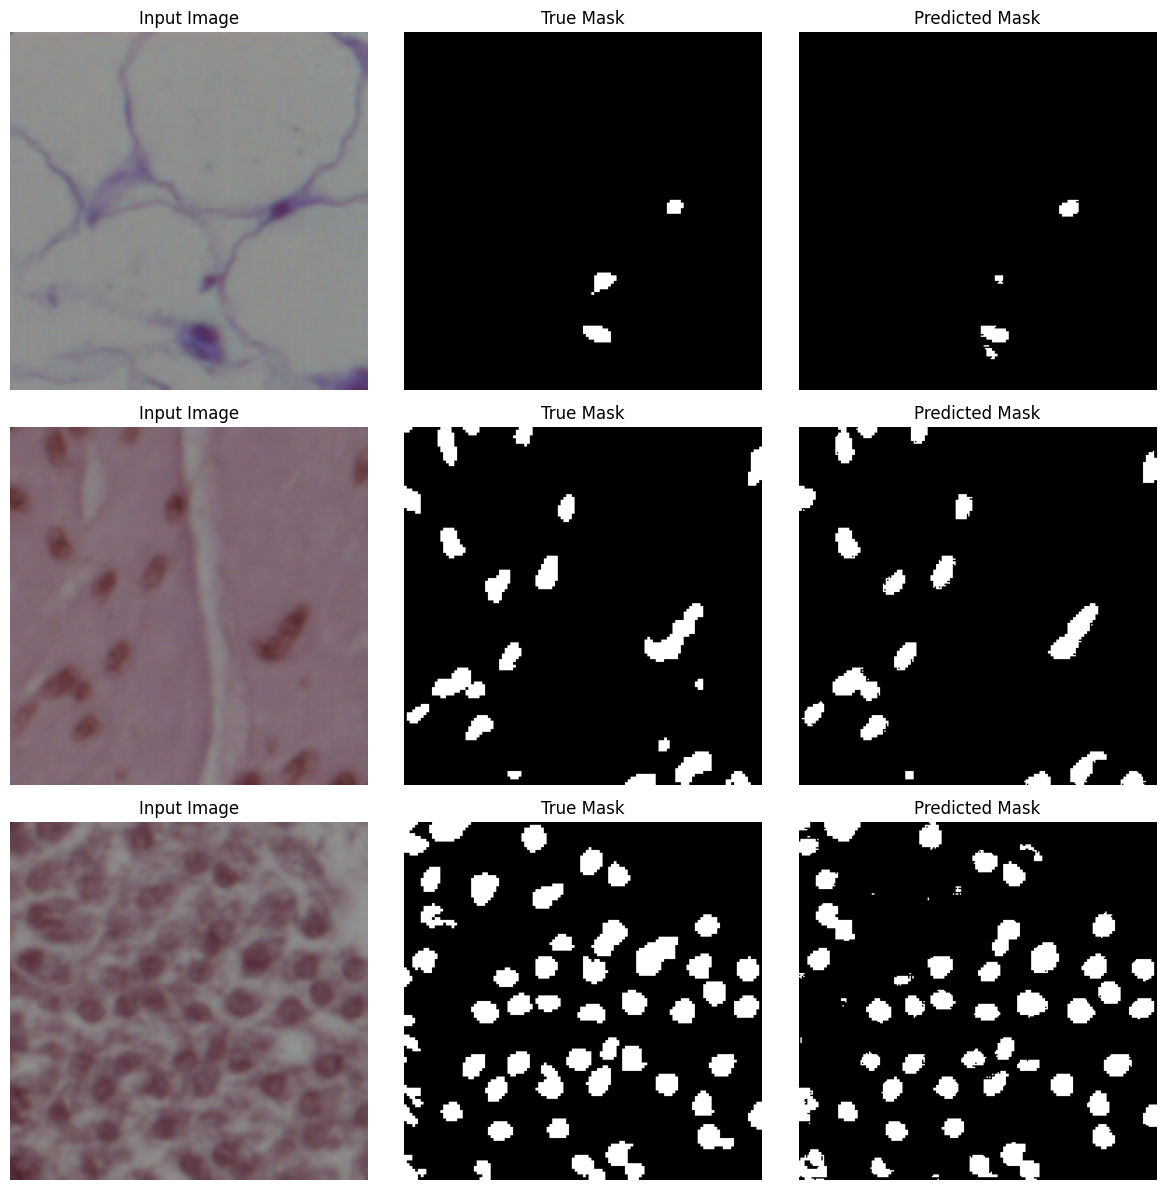

In [ ]:
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))       # grab one batch
    imgs = imgs.to(device)
    logits = model(imgs)
    probs = torch.sigmoid(logits).cpu().numpy()
    masks = masks.numpy()

# Number of examples to show
n = 3
fig, axes = plt.subplots(n, 3, figsize=(12, n*4))
for i in range(n):
    img       = imgs[i].permute(1,2,0).cpu().numpy()
    true_mask = masks[i].squeeze()
    pred_mask = (probs[i].squeeze() > 0.5).astype(float)

    axes[i,0].imshow(img)
    axes[i,0].set_title("Input Image")
    axes[i,0].axis("off")

    axes[i,1].imshow(true_mask, cmap="gray")
    axes[i,1].set_title("True Mask")
    axes[i,1].axis("off")

    axes[i,2].imshow(pred_mask, cmap="gray")
    axes[i,2].set_title("Predicted Mask")
    axes[i,2].axis("off")

plt.tight_layout()
plt.show()


### Define IoU Metric

In [ ]:
def iou_coeff(preds, targets, eps=1e-6):
    """
    preds, targets: torch.Tensor of shape (B,1,H,W) with 0/1 values
    returns mean IoU over the batch.
    """
    preds_flat = preds.view(preds.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)
    intersection = (preds_flat * targets_flat).sum(1)
    union = preds_flat.sum(1) + targets_flat.sum(1) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


### Evaluate on Held-Out Test Set

In [ ]:
# (Here we reuse val_loader as a test set; if you have a separate test split, swap in test_loader)

model.eval()
test_loss = 0.0
test_dice = 0.0
test_iou  = 0.0
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        logits = model(imgs)
        test_loss += criterion(logits, masks).item() * imgs.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        test_dice += dice_coeff(preds, masks).item() * imgs.size(0)
        test_iou  += iou_coeff(preds, masks) * imgs.size(0)

n_test = len(val_ds)
print(f"Test Loss: {test_loss/n_test:.4f}")
print(f"Test Dice: {test_dice/n_test:.4f}")
print(f"Test  IoU: {test_iou/n_test:.4f}")


Test Loss: 0.1407
Test Dice: 0.8264
Test  IoU: 0.6747


### Threshold Tuning Curve

In [ ]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
results = []

model.eval()
with torch.no_grad():
    # collect all logits and masks
    all_logits, all_masks = [], []
    for imgs, masks in val_loader:
        logits = model(imgs.to(device))
        all_logits.append(logits.cpu())
        all_masks.append(masks)
    all_logits = torch.cat(all_logits)
    all_masks  = torch.cat(all_masks)

for thr in thresholds:
    preds = (torch.sigmoid(all_logits) > thr).float()
    d = dice_coeff(preds, all_masks).item()
    j = iou_coeff(preds, all_masks)
    results.append((thr, d, j))

# Display
print(" Thr | Dice   |  IoU")
print("------------------------")
for thr, d, j in results:
    print(f" {thr:.1f} | {d:.4f} | {j:.4f}")


 Thr | Dice   |  IoU
------------------------
 0.3 | 0.8244 | 0.6662
 0.4 | 0.8311 | 0.6760
 0.5 | 0.8307 | 0.6747
 0.6 | 0.8211 | 0.6589
 0.7 | 0.8009 | 0.6271


### Error Analysis – Worst-Performing Samples

Worst 5 samples by Dice:
 Sample 095 – Dice: 0.3330
 Sample 056 – Dice: 0.5214
 Sample 021 – Dice: 0.5367
 Sample 034 – Dice: 0.5670
 Sample 007 – Dice: 0.5804


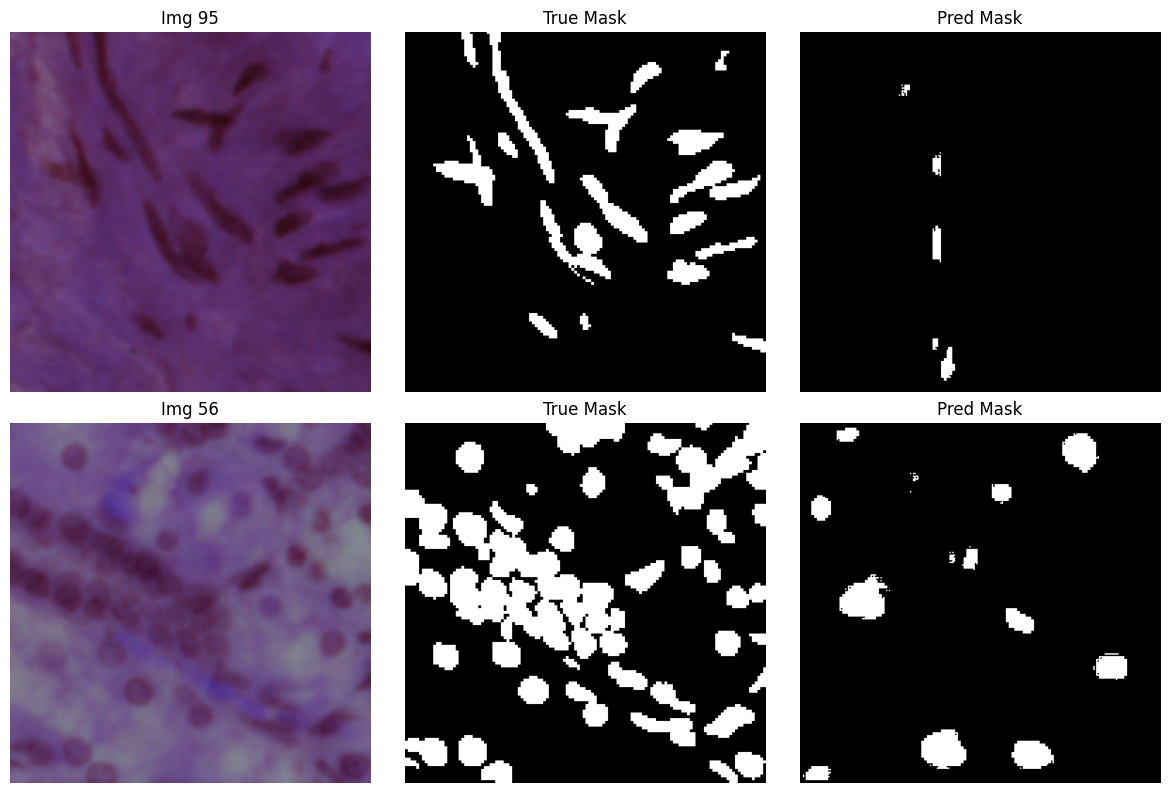

In [ ]:
# Compute per-sample Dice on val set
per_image = []
with torch.no_grad():
    for i in range(len(all_masks)):
        pred = (torch.sigmoid(all_logits[i:i+1]) > 0.5).float()
        true = all_masks[i:i+1]
        per_dice = dice_coeff(pred, true).item()
        per_image.append((i, per_dice))

# Sort and print bottom 5
per_image.sort(key=lambda x: x[1])
print("Worst 5 samples by Dice:")
for idx, d in per_image[:5]:
    print(f" Sample {idx:03d} – Dice: {d:.4f}")

# Visualize a couple
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for row, (idx, _) in enumerate(per_image[:2]):
    img = X_tensor[idx].permute(1,2,0).numpy()
    true = Y_tensor[idx].squeeze().numpy()
    pred = (torch.sigmoid(all_logits[idx:idx+1])[0].squeeze() > 0.5).numpy()

    axes[row,0].imshow(img); axes[row,0].set_title(f"Img {idx}")
    axes[row,1].imshow(true, cmap='gray'); axes[row,1].set_title("True Mask")
    axes[row,2].imshow(pred, cmap='gray'); axes[row,2].set_title("Pred Mask")

for ax in axes.flatten(): 
    ax.axis('off')
plt.tight_layout()
plt.show()


### Post‐processing cleanup function

In [ ]:

def clean_mask(mask, min_size=100):
    """
    Remove connected components smaller than `min_size` pixels.
    mask: 2D numpy array (H, W), values 0 or 1
    """
    # Ensure binary uint8
    m = (mask > 0).astype(np.uint8)
    # Connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
    cleaned = np.zeros_like(m)
    # Skip label 0 (background)
    for lbl in range(1, num_labels):
        area = stats[lbl, cv2.CC_STAT_AREA]
        if area >= min_size:
            cleaned[labels == lbl] = 1
    return cleaned


### Apply cleanup in inference & visualize before vs. after

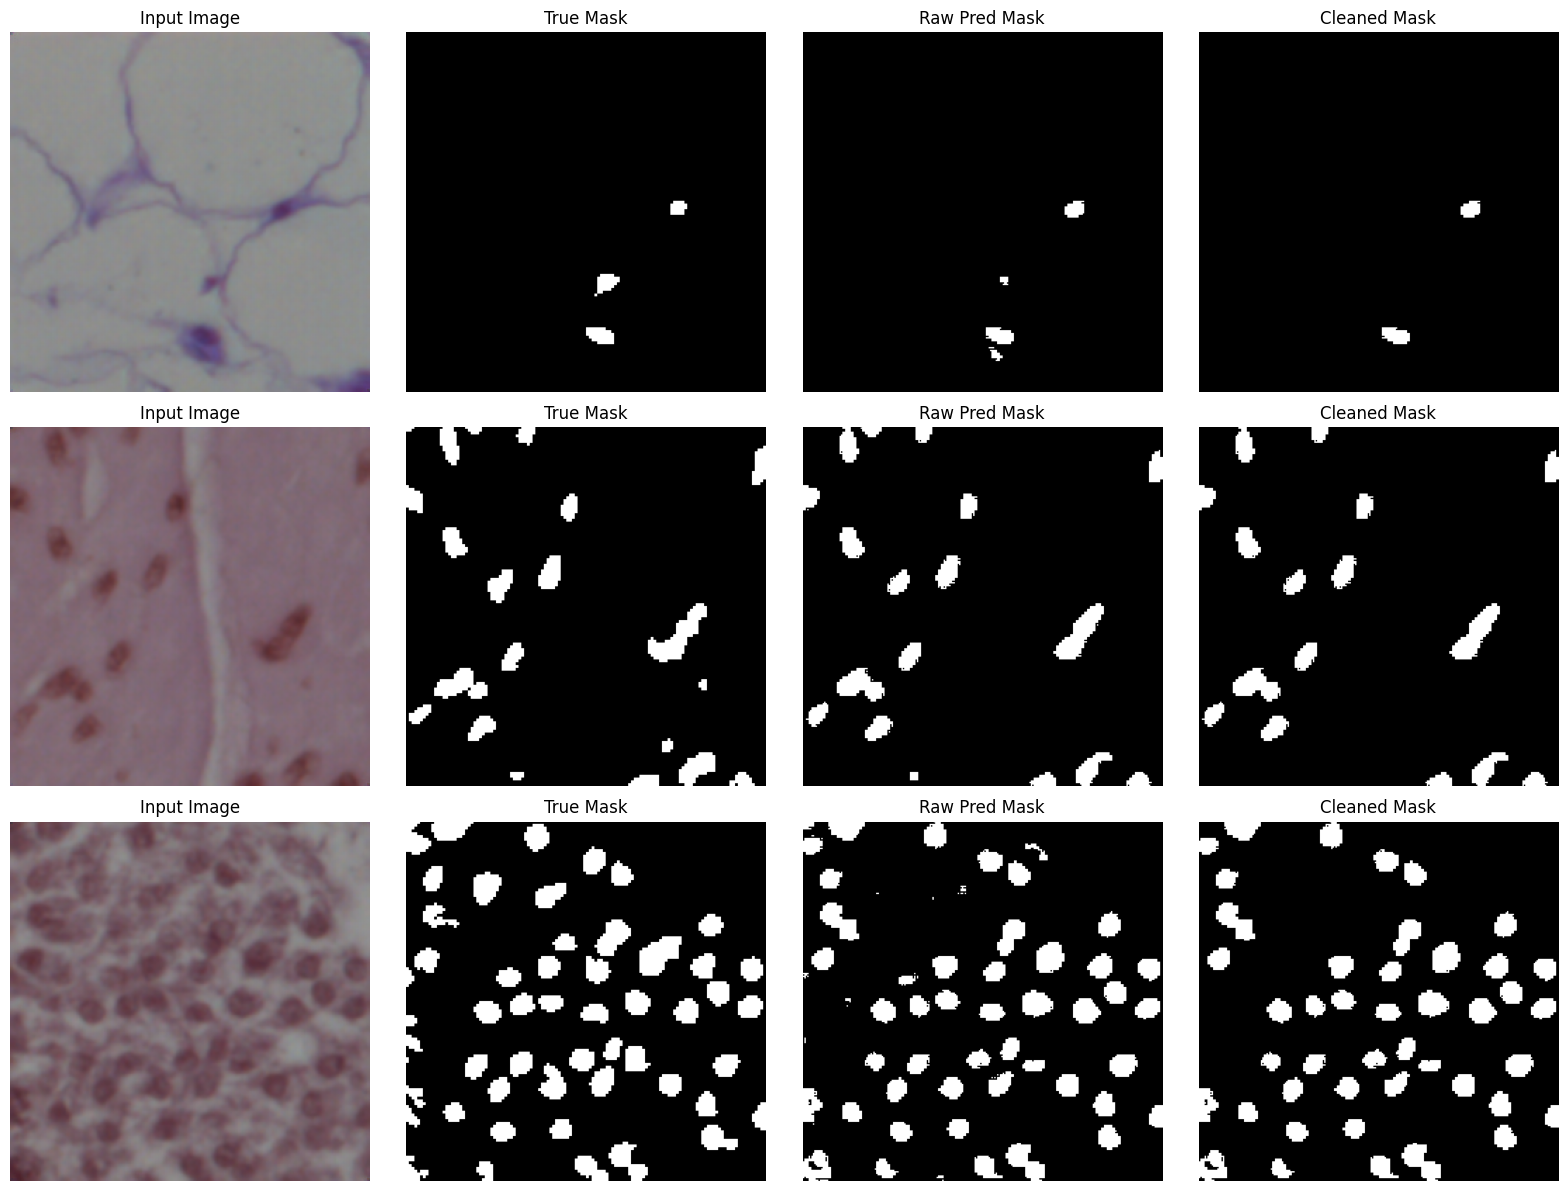

In [ ]:
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(val_loader))
    imgs = imgs.to(device)
    logits = model(imgs)
    probs = torch.sigmoid(logits).cpu().numpy()


num_vis = 3
fig, axes = plt.subplots(num_vis, 4, figsize=(16, num_vis * 4))
for i in range(num_vis):
    img = imgs[i].permute(1,2,0).cpu().numpy()
    true_m = masks[i].squeeze().cpu().numpy()
    raw_pred = (probs[i].squeeze() > 0.5).astype(np.uint8)
    clean_pred = clean_mask(raw_pred, min_size=100)

    axes[i,0].imshow(img);      axes[i,0].set_title('Input Image');   axes[i,0].axis('off')
    axes[i,1].imshow(true_m, cmap='gray'); axes[i,1].set_title('True Mask');     axes[i,1].axis('off')
    axes[i,2].imshow(raw_pred, cmap='gray'); axes[i,2].set_title('Raw Pred Mask'); axes[i,2].axis('off')
    axes[i,3].imshow(clean_pred, cmap='gray'); axes[i,3].set_title('Cleaned Mask');  axes[i,3].axis('off')

plt.tight_layout()
plt.show()


In [87]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from glob import glob
from tqdm import tqdm

# ========== CONFIG ==========
SR_ROOT = "sr_edsr_me_data_all"  # root folder of super-resolved images per organ
SAVE_ROOT = "segmented_output_cleaned"  # where to save cleaned masks
IMG_SIZE = (256, 256)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [88]:
for organ in sorted(os.listdir(SR_ROOT)):
    organ_path = os.path.join(SR_ROOT, organ)
    if not os.path.isdir(organ_path):
        continue

    print(f"🧠 Saving masks for {organ}")
    image_paths = sorted(glob(os.path.join(organ_path, "*.png")))
    save_dir = os.path.join(SAVE_ROOT, organ)
    os.makedirs(save_dir, exist_ok=True)

    for i, path in enumerate(tqdm(image_paths)):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE).astype(np.float32) / 255.0
        tensor = torch.from_numpy(img.transpose(2, 0, 1)).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(tensor)
            probs = torch.sigmoid(logits).squeeze().cpu().numpy()
            binary = (probs > 0.5).astype(np.uint8)
            cleaned = clean_mask(binary, min_size=100)

        out_path = os.path.join(save_dir, f"seg_{i:03d}.png")
        Image.fromarray(cleaned * 255).save(out_path)

    print(f"✅ Done with {organ}, saved to {save_dir}")


🧠 Saving masks for human_bladder


100%|██████████| 12/12 [00:00<00:00, 24.15it/s]


✅ Done with human_bladder, saved to segmented_output_cleaned\human_bladder
🧠 Saving masks for human_brain


100%|██████████| 12/12 [00:00<00:00, 66.83it/s]


✅ Done with human_brain, saved to segmented_output_cleaned\human_brain
🧠 Saving masks for human_cardia


100%|██████████| 12/12 [00:00<00:00, 66.75it/s]


✅ Done with human_cardia, saved to segmented_output_cleaned\human_cardia
🧠 Saving masks for human_cerebellum


100%|██████████| 12/12 [00:00<00:00, 64.97it/s]


✅ Done with human_cerebellum, saved to segmented_output_cleaned\human_cerebellum
🧠 Saving masks for human_epiglottis


100%|██████████| 11/11 [00:00<00:00, 65.33it/s]


✅ Done with human_epiglottis, saved to segmented_output_cleaned\human_epiglottis
🧠 Saving masks for human_jejunum


100%|██████████| 10/10 [00:00<00:00, 67.17it/s]


✅ Done with human_jejunum, saved to segmented_output_cleaned\human_jejunum
🧠 Saving masks for human_kidney


100%|██████████| 11/11 [00:00<00:00, 67.81it/s]


✅ Done with human_kidney, saved to segmented_output_cleaned\human_kidney
🧠 Saving masks for human_liver


100%|██████████| 40/40 [00:00<00:00, 66.77it/s]


✅ Done with human_liver, saved to segmented_output_cleaned\human_liver
🧠 Saving masks for human_lung


100%|██████████| 11/11 [00:00<00:00, 67.34it/s]


✅ Done with human_lung, saved to segmented_output_cleaned\human_lung
🧠 Saving masks for human_melanoma


100%|██████████| 12/12 [00:00<00:00, 65.87it/s]


✅ Done with human_melanoma, saved to segmented_output_cleaned\human_melanoma
🧠 Saving masks for human_muscle


100%|██████████| 9/9 [00:00<00:00, 65.72it/s]


✅ Done with human_muscle, saved to segmented_output_cleaned\human_muscle
🧠 Saving masks for human_oesophagus


100%|██████████| 47/47 [00:00<00:00, 67.38it/s]


✅ Done with human_oesophagus, saved to segmented_output_cleaned\human_oesophagus
🧠 Saving masks for human_pancreas


100%|██████████| 44/44 [00:00<00:00, 66.96it/s]


✅ Done with human_pancreas, saved to segmented_output_cleaned\human_pancreas
🧠 Saving masks for human_peritoneum


100%|██████████| 12/12 [00:00<00:00, 65.29it/s]


✅ Done with human_peritoneum, saved to segmented_output_cleaned\human_peritoneum
🧠 Saving masks for human_placenta


100%|██████████| 40/40 [00:00<00:00, 67.34it/s]


✅ Done with human_placenta, saved to segmented_output_cleaned\human_placenta
🧠 Saving masks for human_pylorus


100%|██████████| 12/12 [00:00<00:00, 62.69it/s]


✅ Done with human_pylorus, saved to segmented_output_cleaned\human_pylorus
🧠 Saving masks for human_rectum


100%|██████████| 12/12 [00:00<00:00, 66.40it/s]


✅ Done with human_rectum, saved to segmented_output_cleaned\human_rectum
🧠 Saving masks for human_salivory


100%|██████████| 44/44 [00:00<00:00, 66.60it/s]


✅ Done with human_salivory, saved to segmented_output_cleaned\human_salivory
🧠 Saving masks for human_spleen


100%|██████████| 34/34 [00:00<00:00, 66.25it/s]


✅ Done with human_spleen, saved to segmented_output_cleaned\human_spleen
🧠 Saving masks for human_testis


100%|██████████| 12/12 [00:00<00:00, 66.44it/s]


✅ Done with human_testis, saved to segmented_output_cleaned\human_testis
🧠 Saving masks for human_tongue


100%|██████████| 40/40 [00:00<00:00, 67.13it/s]


✅ Done with human_tongue, saved to segmented_output_cleaned\human_tongue
🧠 Saving masks for human_tonsile


100%|██████████| 12/12 [00:00<00:00, 64.57it/s]


✅ Done with human_tonsile, saved to segmented_output_cleaned\human_tonsile
🧠 Saving masks for human_umbilical


100%|██████████| 11/11 [00:00<00:00, 67.63it/s]


✅ Done with human_umbilical, saved to segmented_output_cleaned\human_umbilical
🧠 Saving masks for mouse_femur


100%|██████████| 6/6 [00:00<00:00, 63.88it/s]


✅ Done with mouse_femur, saved to segmented_output_cleaned\mouse_femur
🧠 Saving masks for mouse_heart


100%|██████████| 28/28 [00:00<00:00, 64.19it/s]


✅ Done with mouse_heart, saved to segmented_output_cleaned\mouse_heart
🧠 Saving masks for mouse_kidney


100%|██████████| 40/40 [00:00<00:00, 65.77it/s]


✅ Done with mouse_kidney, saved to segmented_output_cleaned\mouse_kidney
🧠 Saving masks for mouse_liver


100%|██████████| 36/36 [00:00<00:00, 66.89it/s]


✅ Done with mouse_liver, saved to segmented_output_cleaned\mouse_liver
🧠 Saving masks for mouse_muscle


100%|██████████| 28/28 [00:00<00:00, 64.40it/s]


✅ Done with mouse_muscle, saved to segmented_output_cleaned\mouse_muscle
🧠 Saving masks for mouse_spleen


100%|██████████| 7/7 [00:00<00:00, 65.33it/s]


✅ Done with mouse_spleen, saved to segmented_output_cleaned\mouse_spleen
🧠 Saving masks for mouse_subscapula


100%|██████████| 42/42 [00:00<00:00, 66.65it/s]


✅ Done with mouse_subscapula, saved to segmented_output_cleaned\mouse_subscapula
🧠 Saving masks for mouse_thymus


100%|██████████| 6/6 [00:00<00:00, 63.26it/s]

✅ Done with mouse_thymus, saved to segmented_output_cleaned\mouse_thymus


### Inspect component‐size distribution to pick a good min_size

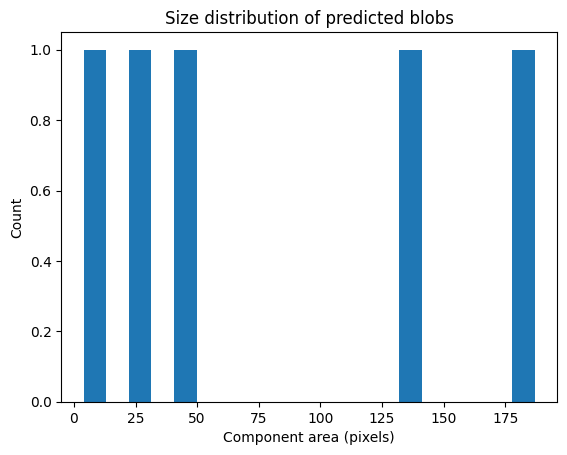

Areas summary (min,10%,25%,50%,75%,90%,max):
4 [ 14.4  30.   42.  137.  167. ] 187


In [ ]:
# Take one example raw mask (0/1) from your validation set
raw = (probs[0].squeeze() > 0.5).astype(np.uint8)

# Compute connected‐component stats
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(raw, connectivity=8)
areas = stats[1:, cv2.CC_STAT_AREA]  # skip background

# Plot histogram
plt.hist(areas, bins=20)
plt.xlabel("Component area (pixels)")
plt.ylabel("Count")
plt.title("Size distribution of predicted blobs")
plt.show()

# Print some percentiles
print("Areas summary (min,10%,25%,50%,75%,90%,max):")
print(np.min(areas), np.percentile(areas, [10,25,50,75,90]), np.max(areas))


### Define a lighter cleanup using morphological opening

In [ ]:
def clean_mask_opening(mask, kernel_size=3):
    """
    Remove very small noise via morphological opening.
    mask: 2D array of 0/1
    kernel_size: size of structuring element
    """
    m = (mask > 0).astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    opened = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel)
    return (opened > 0).astype(np.uint8)


### Compare raw, CC‐cleanup, and opening cleanup

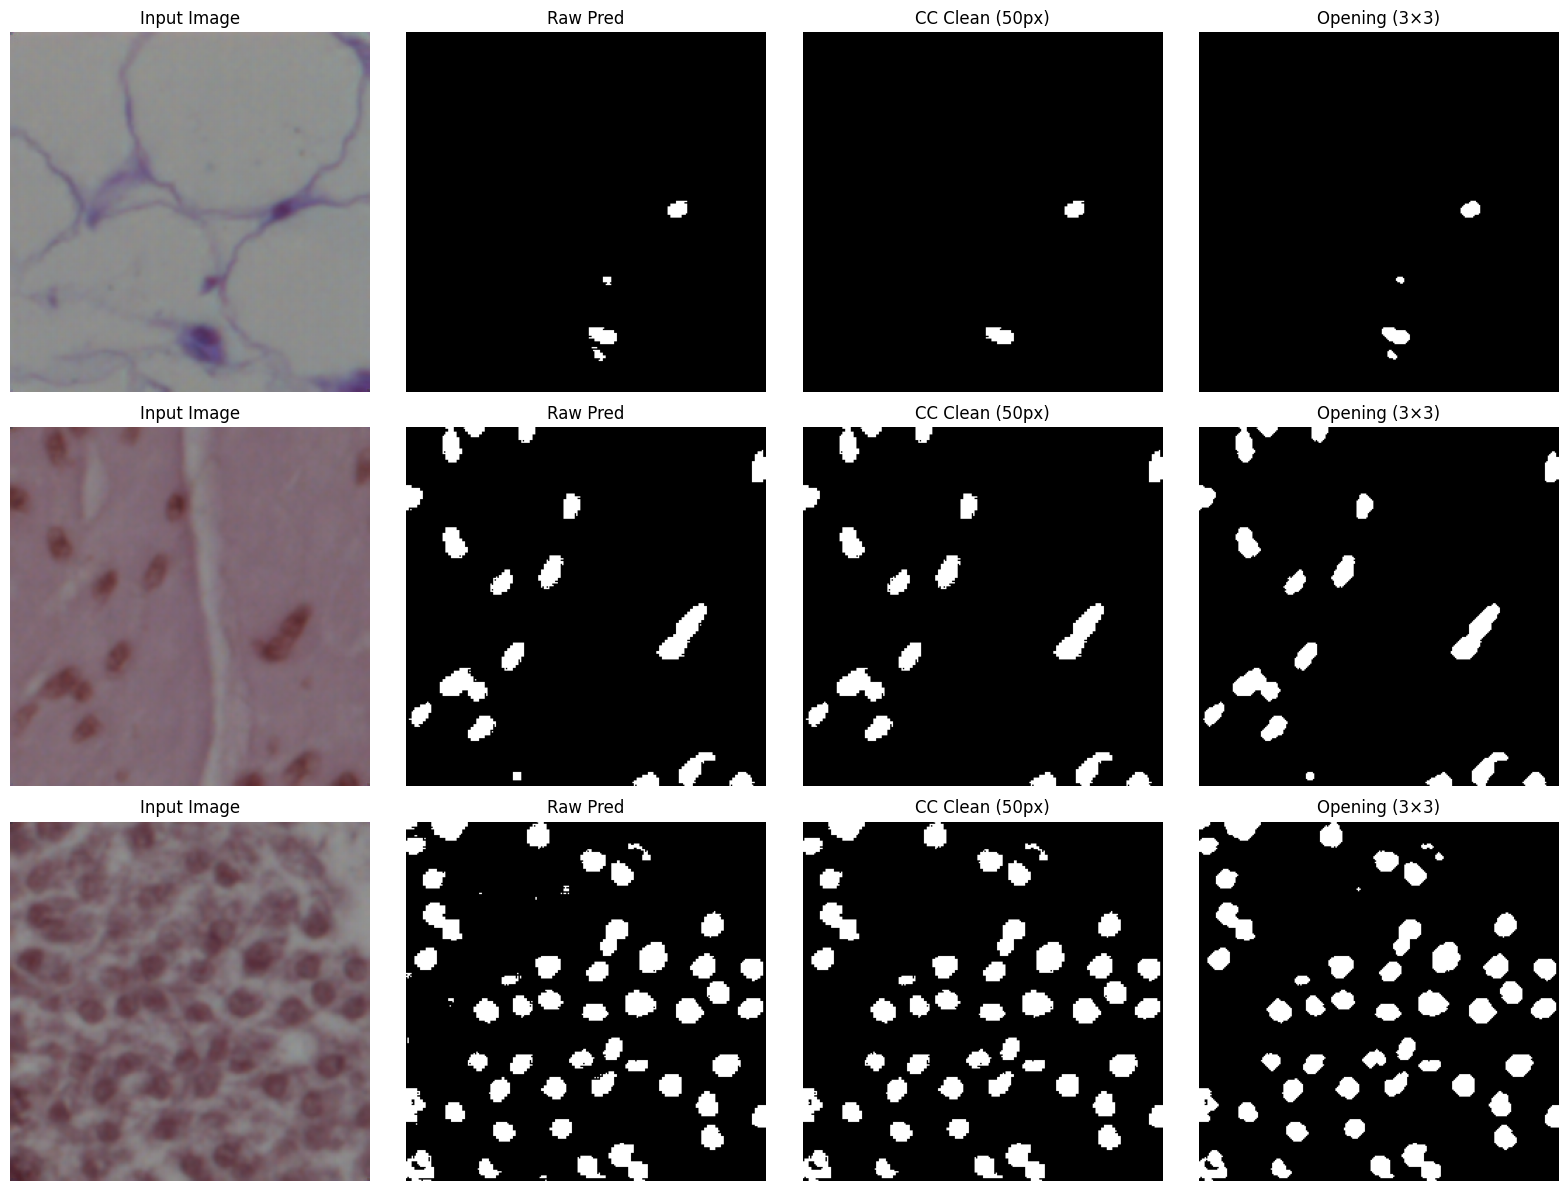

In [ ]:
num_vis = 3
fig, axes = plt.subplots(num_vis, 4, figsize=(16, num_vis*4))
for i in range(num_vis):
    img = imgs[i].permute(1,2,0).cpu().numpy()
    true_m = masks[i].squeeze().cpu().numpy()
    raw_pred = (probs[i].squeeze() > 0.5).astype(np.uint8)
    cc_clean = clean_mask(raw_pred, min_size=50)       # try a smaller threshold
    open_clean = clean_mask_opening(raw_pred, 3)       # opening with 3×3 kernel

    axes[i,0].imshow(img);      axes[i,0].set_title('Input Image');   axes[i,0].axis('off')
    axes[i,1].imshow(raw_pred, cmap='gray'); axes[i,1].set_title('Raw Pred');   axes[i,1].axis('off')
    axes[i,2].imshow(cc_clean, cmap='gray');  axes[i,2].set_title('CC Clean (50px)'); axes[i,2].axis('off')
    axes[i,3].imshow(open_clean, cmap='gray');axes[i,3].set_title('Opening (3×3)'); axes[i,3].axis('off')

plt.tight_layout()
plt.show()


## **3D Cell Reconstruction**

In [19]:
!pip install numpy pillow matplotlib scikit-image scipy trimesh


Original volume shape: (28, 256, 256)


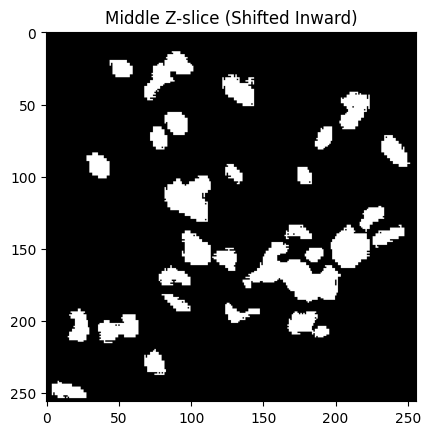

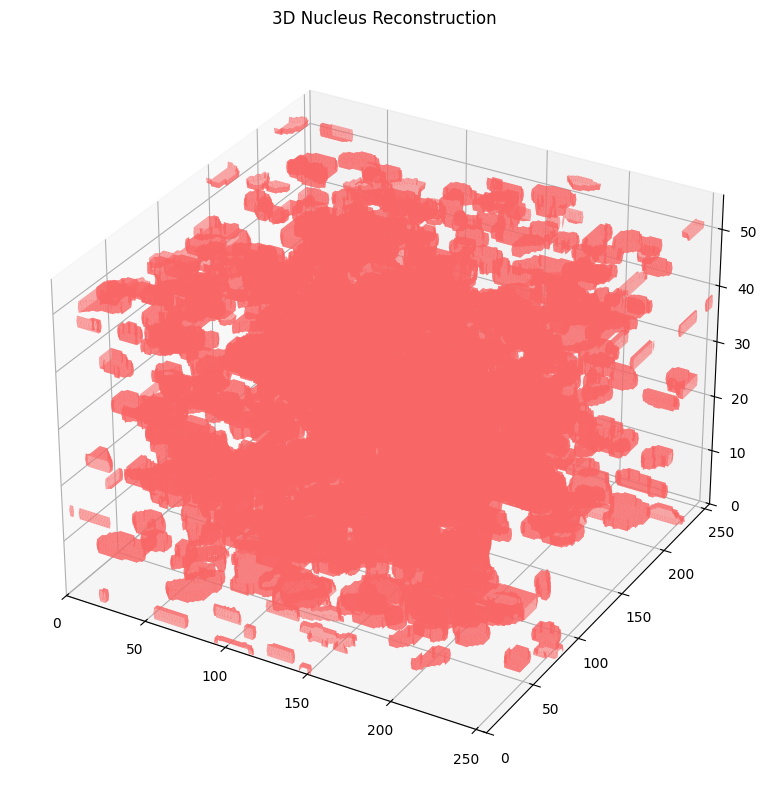

In [37]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
import trimesh

# ===========================
# CONFIGURATION
# ===========================
input_dir = "segmented_output_cleaned/mouse_heart"  # 
z_spacing = 2.0                         # adjust this for aesthetics or realism
y_spacing = 1.0
x_spacing = 1.0
compress_factor = 0.5                  # how aggressively to shift slices inward

# ===========================
# LOAD SEGMENTED SLICES
# ===========================
slices = sorted([f for f in os.listdir(input_dir) if f.endswith('.png')])
volume = []

for fname in slices:
    img = Image.open(os.path.join(input_dir, fname)).convert('L')
    binary = (np.array(img) > 0).astype(np.uint8)
    volume.append(binary)

volume = np.stack(volume, axis=0)  # Shape: (Z, Y, X)
print("Original volume shape:", volume.shape)

# ===========================
# SHIFT SLICES TOWARD CENTER
# ===========================
def center_compress_shift(volume, compress_factor=0.5):
    zdim, ydim, xdim = volume.shape
    shifted_vol = np.zeros_like(volume)
    for z in range(zdim):
        shift = int((zdim // 2 - z) * compress_factor)
        y_slice = np.roll(volume[z], shift=shift, axis=0)
        xy_slice = np.roll(y_slice, shift=shift, axis=1)
        shifted_vol[z] = xy_slice
    return shifted_vol

volume = center_compress_shift(volume, compress_factor=compress_factor)

# ===========================
# OPTIONAL VISUAL CHECK
# ===========================
plt.imshow(volume[volume.shape[0] // 2], cmap='gray')
plt.title("Middle Z-slice (Shifted Inward)")
plt.show()

# ===========================
# MARCHING CUBES
# ===========================
verts, faces, normals, values = measure.marching_cubes(volume, level=0.5)

# Apply voxel spacing and re-order to (x, y, z)
scaled_verts = verts * np.array([z_spacing, y_spacing, x_spacing])
scaled_verts = scaled_verts[:, [2, 1, 0]]

# ===========================
# 3D PLOT
# ===========================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(scaled_verts[faces], alpha=0.7)
mesh.set_facecolor([0.98, 0.4, 0.4])  
ax.add_collection3d(mesh)

ax.set_xlim(0, volume.shape[2])
ax.set_ylim(0, volume.shape[1])
ax.set_zlim(0, volume.shape[0] * z_spacing)

ax.set_title("3D Nucleus Reconstruction")
plt.tight_layout()
plt.show()


Original volume shape: (11, 256, 256)


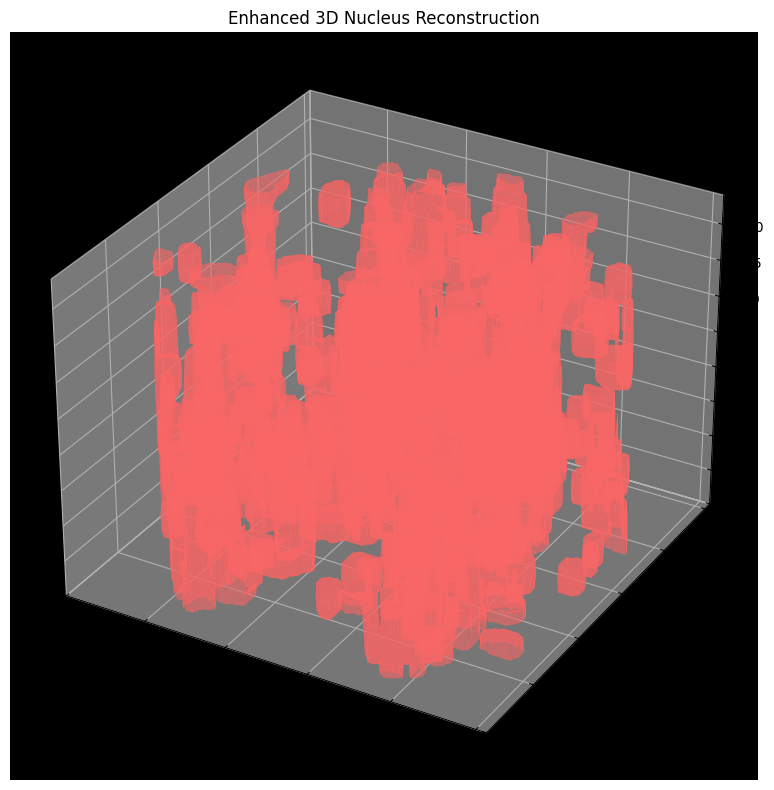

Saved 3D model as nucleus_spherical.stl


In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from scipy import ndimage

# =========================== 
# CONFIGURATION 
# =========================== 
input_dir = "segmented_output_cleaned/human_kidney"

# Adjust these parameters to control the appearance
z_spacing = 2.0            # Spacing between slices
y_spacing = 1.0            # Pixel height
x_spacing = 1.0            # Pixel width
compress_factor = 0.8      # Increased from 0.5 to bring points closer
smoothing_sigma = 1.0      # Gaussian smoothing to blend the blobs
sphere_factor = 0.3        # How strongly to enforce a spherical shape

# =========================== 
# LOAD SEGMENTED SLICES 
# =========================== 
def load_volume(input_dir):
    slices = sorted([f for f in os.listdir(input_dir) if f.endswith('.png')])
    volume = []
    
    for fname in slices:
        img = Image.open(os.path.join(input_dir, fname)).convert('L')
        binary = (np.array(img) > 0).astype(np.uint8)
        volume.append(binary)
    
    volume = np.stack(volume, axis=0)  # Shape: (Z, Y, X)
    print(f"Original volume shape: {volume.shape}")
    return volume

# =========================== 
# ENHANCE FOR SPHERICAL SHAPE
# =========================== 
def spherify_volume(volume, compress_factor=0.8, sphere_factor=0.3):
    """Apply transformations to make the volume more spherical"""
    zdim, ydim, xdim = volume.shape
    
    # Create coordinate grid
    z, y, x = np.ogrid[:zdim, :ydim, :xdim]
    
    # Calculate center points
    center_z, center_y, center_x = zdim // 2, ydim // 2, xdim // 2
    
    # Shift slices toward center (similar to original code but enhanced)
    shifted_vol = np.zeros_like(volume)
    for z_idx in range(zdim):
        # Calculate shift based on distance from center slice
        shift = int((center_z - z_idx) * compress_factor)
        
        # Apply shift in both dimensions
        y_slice = np.roll(volume[z_idx], shift=shift, axis=0)
        xy_slice = np.roll(y_slice, shift=shift, axis=1)
        shifted_vol[z_idx] = xy_slice

    # Apply spherical transformation
    if sphere_factor > 0:
        spherical_vol = np.zeros_like(shifted_vol)
        
        # Calculate distance from center for each voxel
        dist_from_center = np.sqrt(
            ((z - center_z) * z_spacing)**2 + 
            ((y - center_y) * y_spacing)**2 + 
            ((x - center_x) * x_spacing)**2
        )
        
        # Find non-zero voxels (our blobs)
        blob_indices = np.where(shifted_vol > 0)
        
        # Create a copy for manipulation
        spherical_vol = shifted_vol.copy()
        
        # Adjust voxel values based on distance from center
        # Further away points get reduced intensity to emphasize sphere
        for i in range(len(blob_indices[0])):
            z_idx, y_idx, x_idx = blob_indices[0][i], blob_indices[1][i], blob_indices[2][i]
            
            # Calculate normalized distance from center (0 to 1)
            max_possible_dist = np.sqrt((zdim*z_spacing)**2 + (ydim*y_spacing)**2 + (xdim*x_spacing)**2) / 2
            norm_dist = dist_from_center[z_idx, y_idx, x_idx] / max_possible_dist
            
            # Apply distance-based adjustment
            if norm_dist > 0.7:  # Only adjust points far from center
                spherical_vol[z_idx, y_idx, x_idx] *= (1 - sphere_factor * (norm_dist - 0.7))
        
        return spherical_vol
    
    return shifted_vol

# =========================== 
# PROCESSING PIPELINE
# =========================== 
def process_volume(volume, smoothing_sigma=1.0):
    # Step 1: Make the volume more spherical
    enhanced_vol = spherify_volume(volume, compress_factor, sphere_factor)
    
    # Step 2: Apply smoothing to blend the blobs
    smoothed_vol = ndimage.gaussian_filter(enhanced_vol.astype(float), sigma=smoothing_sigma)
    
    # Step 3: Rethreshold to binary
    binary_vol = (smoothed_vol > 0.3).astype(np.uint8)  # Adjust threshold as needed
    
    return binary_vol

# =========================== 
# MAIN EXECUTION
# =========================== 
# Load the volume
volume = load_volume(input_dir)

# Process the volume to enhance spherical appearance
processed_volume = process_volume(volume, smoothing_sigma)

# Generate 3D mesh using marching cubes
verts, faces, normals, values = measure.marching_cubes(processed_volume, level=0.5)

# Apply voxel spacing 
scaled_verts = verts * np.array([z_spacing, y_spacing, x_spacing])
# Reorder to (x, y, z) for visualization
scaled_verts = scaled_verts[:, [2, 1, 0]]  

# =========================== 
# 3D VISUALIZATION
# =========================== 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(scaled_verts[faces], alpha=0.7)
mesh.set_facecolor([0.98, 0.4, 0.4])  # Same color as original

ax.add_collection3d(mesh)

ax.set_xlim(0, volume.shape[2])
ax.set_ylim(0, volume.shape[1])
ax.set_zlim(0, volume.shape[0] * z_spacing)

ax.set_title("Enhanced 3D Nucleus Reconstruction")
plt.tight_layout()
plt.show()

# Optional: Save the model for later use
try:
    # Create mesh object
    nucleus_mesh = trimesh.Trimesh(vertices=scaled_verts, faces=faces)
    # Save as STL
    nucleus_mesh.export('nucleus_spherical.stl')
    print("Saved 3D model as nucleus_spherical.stl")
except Exception as e:
    print(f"Could not save STL file: {e}")

Original volume shape: (12, 256, 256)


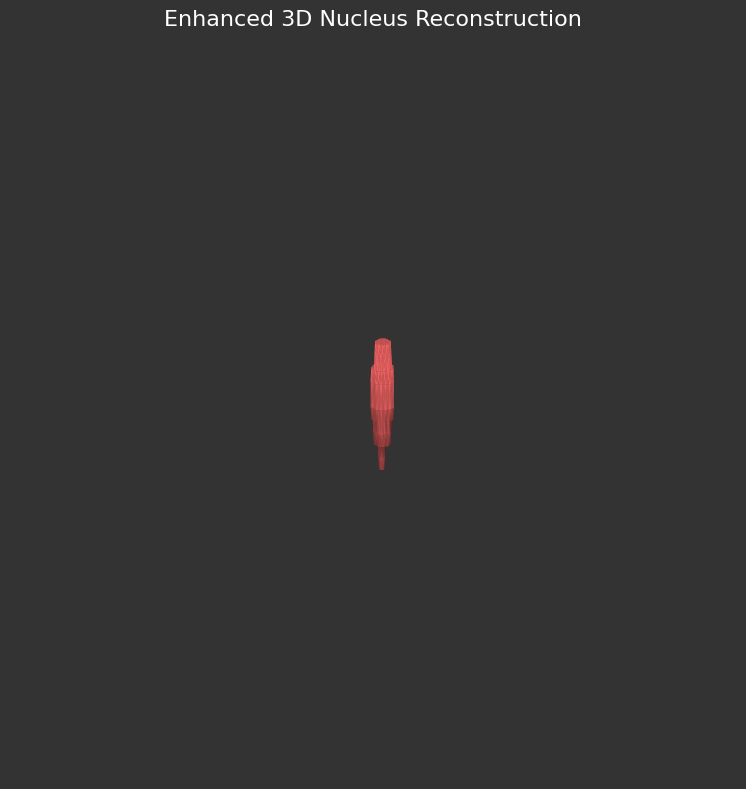

Saved 3D model as nucleus_spherical.stl


In [12]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from scipy import ndimage

# =========================== 
# CONFIGURATION 
# =========================== 
input_dir = "segmented_output_cleaned/human_rectum"

# Adjust these parameters to control the appearance
z_spacing = 3.0            # Spacing between slices
y_spacing = 1.0            # Pixel height
x_spacing = 1.0            # Pixel width
compress_factor = 0.8     # Increased significantly to bring points closer together
smoothing_sigma = 2.5      # Increased smoothing to blend the blobs better
sphere_factor = 0.7        # Increased to more strongly enforce a spherical shape
radial_pull = 0.4          # New parameter to pull points toward center
dilation_iterations = 2    # Apply morphological dilation to connect nearby points

# =========================== 
# LOAD SEGMENTED SLICES 
# =========================== 
def load_volume(input_dir):
    slices = sorted([f for f in os.listdir(input_dir) if f.endswith('.png')])
    volume = []
    
    for fname in slices:
        img = Image.open(os.path.join(input_dir, fname)).convert('L')
        binary = (np.array(img) > 0).astype(np.uint8)
        volume.append(binary)
    
    volume = np.stack(volume, axis=0)  # Shape: (Z, Y, X)
    print(f"Original volume shape: {volume.shape}")
    return volume

# =========================== 
# ENHANCE FOR SPHERICAL SHAPE
# =========================== 
def spherify_volume(volume, compress_factor=1.2, sphere_factor=0.7, radial_pull=0.4):
    """Apply advanced transformations to make the volume more spherical"""
    zdim, ydim, xdim = volume.shape
    
    # Create coordinate grid
    z, y, x = np.ogrid[:zdim, :ydim, :xdim]
    
    # Calculate center points
    center_z, center_y, center_x = zdim // 2, ydim // 2, xdim // 2
    
    # Create spherical mask to guide the transformation
    radius = min(zdim, ydim, xdim) // 2.5  # Target radius for the sphere
    sphere_mask = np.zeros((zdim, ydim, xdim), dtype=np.float32)
    
    # Generate a solid sphere in the center
    for z_idx in range(zdim):
        for y_idx in range(ydim):
            for x_idx in range(xdim):
                dist = np.sqrt(
                    ((z_idx - center_z) * z_spacing) ** 2 +
                    ((y_idx - center_y) * y_spacing) ** 2 +
                    ((x_idx - center_x) * x_spacing) ** 2
                )
                if dist <= radius:
                    sphere_mask[z_idx, y_idx, x_idx] = 1.0 - (dist / radius) ** 2
    
    # Apply radial transformation (pull points toward center)
    transformed_vol = np.zeros_like(volume, dtype=np.float32)
    
    # Find all non-zero voxels
    blob_indices = np.where(volume > 0)
    
    # 3D distance field from center
    z_coords, y_coords, x_coords = np.meshgrid(
        range(zdim), range(ydim), range(xdim), indexing='ij'
    )
    
    # Calculate distances from center
    dz = z_coords - center_z
    dy = y_coords - center_y
    dx = x_coords - center_x
    
    # Calculate the magnitude of the distance vector
    dist_from_center = np.sqrt(dz**2 + dy**2 + dx**2)
    max_dist = np.sqrt(zdim**2 + ydim**2 + xdim**2) / 2
    
    # Normalized distance (0 to 1)
    norm_dist = dist_from_center / max_dist
    
    # Apply radial compression to the coordinates
    new_z = np.zeros_like(z_coords, dtype=np.float32)
    new_y = np.zeros_like(y_coords, dtype=np.float32)
    new_x = np.zeros_like(x_coords, dtype=np.float32)
    
    # Shift points inward based on distance
    for i in range(len(blob_indices[0])):
        z_idx, y_idx, x_idx = blob_indices[0][i], blob_indices[1][i], blob_indices[2][i]
        
        # Get normalized distance
        nd = norm_dist[z_idx, y_idx, x_idx]
        
        # Calculate radial compression factor (stronger for points further out)
        radial_factor = radial_pull * nd ** 2
        
        # Compress coordinates toward center
        new_z[z_idx, y_idx, x_idx] = center_z + (z_idx - center_z) * (1 - radial_factor)
        new_y[z_idx, y_idx, x_idx] = center_y + (y_idx - center_y) * (1 - radial_factor)
        new_x[z_idx, y_idx, x_idx] = center_x + (x_idx - center_x) * (1 - radial_factor)
    
    # Apply the coordinate transformation
    for i in range(len(blob_indices[0])):
        z_idx, y_idx, x_idx = blob_indices[0][i], blob_indices[1][i], blob_indices[2][i]
        
        # Get transformed coordinates (rounding to nearest voxel)
        nz = int(np.round(new_z[z_idx, y_idx, x_idx]))
        ny = int(np.round(new_y[z_idx, y_idx, x_idx]))
        nx = int(np.round(new_x[z_idx, y_idx, x_idx]))
        
        # Ensure coordinates are in bounds
        nz = max(0, min(nz, zdim-1))
        ny = max(0, min(ny, ydim-1))
        nx = max(0, min(nx, xdim-1))
        
        # Set the value in the transformed volume
        transformed_vol[nz, ny, nx] = 1.0
    
    # Also apply the original shift toward center for slices
    shifted_vol = np.zeros_like(volume)
    for z_idx in range(zdim):
        # Calculate shift based on distance from center slice (larger factor now)
        shift = int((center_z - z_idx) * compress_factor)
        
        # Apply shift in both dimensions
        y_slice = np.roll(transformed_vol[z_idx], shift=shift, axis=0)
        xy_slice = np.roll(y_slice, shift=shift, axis=1)
        shifted_vol[z_idx] = xy_slice
    
    # Blend with the spherical mask to enhance spherical shape
    if sphere_factor > 0:
        # Weight the original volume based on distance from ideal sphere
        weighted_vol = shifted_vol * (sphere_factor * sphere_mask + (1 - sphere_factor))
        return weighted_vol
    
    return shifted_vol

# =========================== 
# PROCESSING PIPELINE
# =========================== 
def process_volume(volume, smoothing_sigma=2.5, dilation_iterations=2):
    # Step 1: Make the volume more spherical
    enhanced_vol = spherify_volume(volume, compress_factor, sphere_factor, radial_pull)
    
    # Step 2: Apply morphological dilation to connect nearby points
    if dilation_iterations > 0:
        structure = ndimage.generate_binary_structure(3, 1)  # 3D connectivity
        dilated_vol = ndimage.binary_dilation(
            enhanced_vol > 0.1, structure=structure, iterations=dilation_iterations
        ).astype(np.float32)
    else:
        dilated_vol = enhanced_vol
    
    # Step 3: Apply smoothing to blend the blobs
    smoothed_vol = ndimage.gaussian_filter(dilated_vol, sigma=smoothing_sigma)
    
    # Step 4: Apply additional spherical constraint
    zdim, ydim, xdim = volume.shape
    center_z, center_y, center_x = zdim // 2, ydim // 2, xdim // 2
    z, y, x = np.ogrid[:zdim, :ydim, :xdim]
    
    # Create a spherical weight field (higher in center, lower at edges)
    radius = min(zdim, ydim, xdim) // 2
    dist_from_center = np.sqrt(
        ((z - center_z) * z_spacing)**2 + 
        ((y - center_y) * y_spacing)**2 + 
        ((x - center_x) * x_spacing)**2
    )
    sphere_weight = np.clip(1.0 - (dist_from_center / (radius * 1.5))**2, 0, 1)
    
    # Apply spherical weighting
    weighted_vol = smoothed_vol * sphere_weight
    
    # Step 5: Rethreshold to binary
    binary_vol = (weighted_vol > 0.2).astype(np.uint8)  # Lower threshold to include more volume
    
    return binary_vol

# =========================== 
# MAIN EXECUTION
# =========================== 
# Load the volume
volume = load_volume(input_dir)

# Process the volume to enhance spherical appearance
processed_volume = process_volume(volume, smoothing_sigma)

# Generate 3D mesh using marching cubes
verts, faces, normals, values = measure.marching_cubes(processed_volume, level=0.5)

# Apply voxel spacing 
scaled_verts = verts * np.array([z_spacing, y_spacing, x_spacing])
# Reorder to (x, y, z) for visualization
scaled_verts = scaled_verts[:, [2, 1, 0]]  

# =========================== 
# 3D VISUALIZATION
# =========================== 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Set background color to dark gray for better contrast
ax.set_facecolor((0.2, 0.2, 0.2))
fig.patch.set_facecolor((0.2, 0.2, 0.2))

# Use a proper mesh with lighting for better 3D appearance
mesh = Poly3DCollection(scaled_verts[faces], alpha=0.9)
mesh.set_facecolor([0.98, 0.4, 0.4])
mesh.set_edgecolor('none')  # Remove edges for smoother appearance

# Add directional lighting
light = plt.matplotlib.colors.LightSource(azdeg=315, altdeg=45)
illuminated_surface = light.shade_normals(
    normals, 
    fraction=0.6
)

# Apply illumination to mesh
face_colors = np.ones((len(faces), 4))
face_colors[:, 0] = 0.98  # Red
face_colors[:, 1] = 0.4   # Green
face_colors[:, 2] = 0.4   # Blue

# Adjust colors based on lighting
for i in range(len(faces)):
    face_idx = faces[i]
    avg_normal = np.mean(normals[face_idx], axis=0)
    avg_normal = avg_normal / np.linalg.norm(avg_normal)
    
    # Calculate illumination (dot product with light direction)
    light_dir = np.array([0.7, 0.7, 0.7])  # Light from upper right
    light_dir = light_dir / np.linalg.norm(light_dir)
    illumination = np.dot(avg_normal, light_dir)
    illumination = max(0.4, min(1.0, 0.6 + illumination * 0.5))
    
    # Apply illumination to face color
    face_colors[i, 0:3] *= illumination

mesh.set_facecolors(face_colors)

ax.add_collection3d(mesh)

# Set view limits
ax.set_xlim(0, volume.shape[2])
ax.set_ylim(0, volume.shape[1])
ax.set_zlim(0, volume.shape[0] * z_spacing)

# Improve appearance
ax.grid(False)  # Remove grid
ax.set_axis_off()  # Hide axes
ax.view_init(elev=30, azim=45)  # Set viewing angle

ax.set_title("Enhanced 3D Nucleus Reconstruction", color='white', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Optional: Save the model for later use
try:
    # Create mesh object
    nucleus_mesh = trimesh.Trimesh(vertices=scaled_verts, faces=faces)
    # Save as STL
    nucleus_mesh.export('nucleus_spherical.stl')
    print("Saved 3D model as nucleus_spherical.stl")
except Exception as e:
    print(f"Could not save STL file: {e}")

Original volume shape: (11, 256, 256)


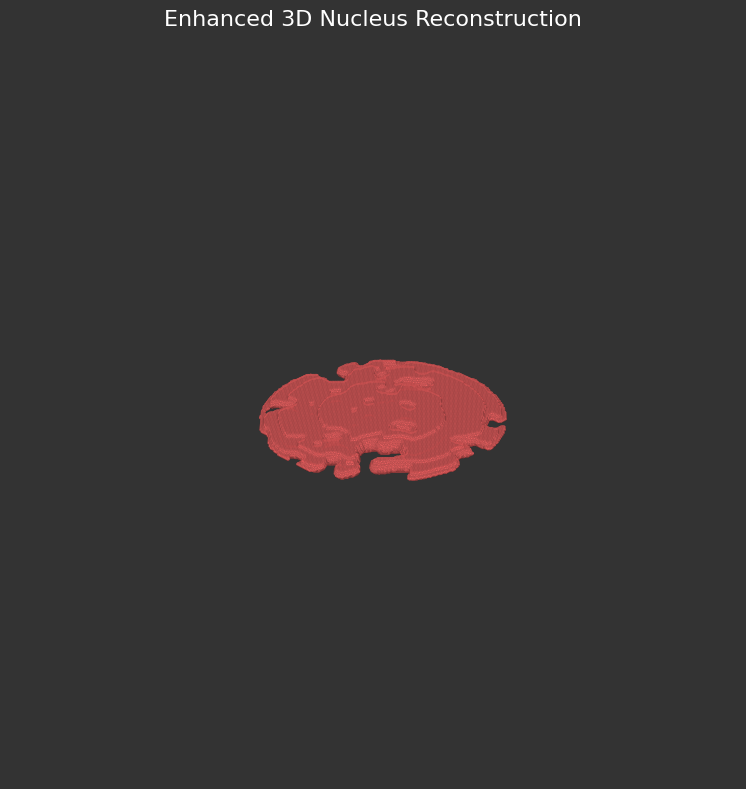

Saved 3D model as nucleus_spherical.stl


In [18]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from scipy import ndimage

# =========================== 
# CONFIGURATION 
# =========================== 
input_dir = "segmented_output_cleaned/human_lung"

# Adjust these parameters to control the appearance
z_spacing = 1.0            # Reduced from 2.0 to make dimensions more uniform
y_spacing = 1.0            # Pixel height
x_spacing = 1.0            # Pixel width
compress_factor = 0.8      # Reduced from 1.2 to prevent over-compression
smoothing_sigma = 2.0      # Slightly reduced smoothing
sphere_factor = 0.8        # Increased to more strongly enforce a spherical shape
radial_pull = 0.3          # Slightly reduced to prevent extreme deformation
dilation_iterations = 2    # Apply morphological dilation to connect nearby points
balance_factor = 0.6       # New parameter to balance x/y/z dimensions

# =========================== 
# LOAD SEGMENTED SLICES 
# =========================== 
def load_volume(input_dir):
    slices = sorted([f for f in os.listdir(input_dir) if f.endswith('.png')])
    volume = []
    
    for fname in slices:
        img = Image.open(os.path.join(input_dir, fname)).convert('L')
        binary = (np.array(img) > 0).astype(np.uint8)
        volume.append(binary)
    
    volume = np.stack(volume, axis=0)  # Shape: (Z, Y, X)
    print(f"Original volume shape: {volume.shape}")
    return volume

# =========================== 
# ENHANCE FOR SPHERICAL SHAPE
# =========================== 
def spherify_volume(volume, compress_factor=0.8, sphere_factor=0.8, radial_pull=0.3, balance_factor=0.6):
    """Apply advanced transformations to make the volume more spherical"""
    zdim, ydim, xdim = volume.shape
    
    # Create coordinate grid
    z, y, x = np.ogrid[:zdim, :ydim, :xdim]
    
    # Calculate center points
    center_z, center_y, center_x = zdim // 2, ydim // 2, xdim // 2
    
    # Compute dimension balance factors to make the result more spherical
    # We'll squeeze the longest dimension and stretch the shortest
    dims = np.array([zdim, ydim, xdim])
    max_dim = np.max(dims)
    dim_factors = max_dim / dims
    dim_factors = 1 + (dim_factors - 1) * balance_factor  # Scale the balancing effect
    
    # Apply the balancing factors to coordinates
    z_factor, y_factor, x_factor = dim_factors
    
    # Create spherical mask to guide the transformation
    radius = min(zdim, ydim, xdim) // 2.5  # Target radius for the sphere
    sphere_mask = np.zeros((zdim, ydim, xdim), dtype=np.float32)
    
    # Generate a solid sphere in the center
    for z_idx in range(zdim):
        for y_idx in range(ydim):
            for x_idx in range(xdim):
                # Apply dimension balancing to make sphere more uniform
                balanced_z = (z_idx - center_z) * z_factor
                balanced_y = (y_idx - center_y) * y_factor
                balanced_x = (x_idx - center_x) * x_factor
                
                dist = np.sqrt(
                    balanced_z**2 + balanced_y**2 + balanced_x**2
                )
                if dist <= radius:
                    sphere_mask[z_idx, y_idx, x_idx] = 1.0 - (dist / radius) ** 2
    
    # Apply radial transformation (pull points toward center)
    transformed_vol = np.zeros_like(volume, dtype=np.float32)
    
    # Find all non-zero voxels
    blob_indices = np.where(volume > 0)
    
    # 3D distance field from center
    z_coords, y_coords, x_coords = np.meshgrid(
        range(zdim), range(ydim), range(xdim), indexing='ij'
    )
    
    # Calculate balanced distances from center
    dz = (z_coords - center_z) * z_factor
    dy = (y_coords - center_y) * y_factor
    dx = (x_coords - center_x) * x_factor
    
    # Calculate the magnitude of the distance vector
    dist_from_center = np.sqrt(dz**2 + dy**2 + dx**2)
    max_dist = np.sqrt((zdim*z_factor)**2 + (ydim*y_factor)**2 + (xdim*x_factor)**2) / 2
    
    # Normalized distance (0 to 1)
    norm_dist = dist_from_center / max_dist
    
    # Apply radial compression to the coordinates
    new_z = np.zeros_like(z_coords, dtype=np.float32)
    new_y = np.zeros_like(y_coords, dtype=np.float32)
    new_x = np.zeros_like(x_coords, dtype=np.float32)
    
    # Shift points inward based on distance
    for i in range(len(blob_indices[0])):
        z_idx, y_idx, x_idx = blob_indices[0][i], blob_indices[1][i], blob_indices[2][i]
        
        # Get normalized distance
        nd = norm_dist[z_idx, y_idx, x_idx]
        
        # Calculate radial compression factor (stronger for points further out)
        radial_factor = radial_pull * nd ** 2
        
        # Apply dimension balancing to coordinates
        # Compress coordinates toward center with dimension-specific factors
        new_z[z_idx, y_idx, x_idx] = center_z + (z_idx - center_z) * (1 - radial_factor) / z_factor
        new_y[z_idx, y_idx, x_idx] = center_y + (y_idx - center_y) * (1 - radial_factor) / y_factor
        new_x[z_idx, y_idx, x_idx] = center_x + (x_idx - center_x) * (1 - radial_factor) / x_factor
    
    # Apply the coordinate transformation
    for i in range(len(blob_indices[0])):
        z_idx, y_idx, x_idx = blob_indices[0][i], blob_indices[1][i], blob_indices[2][i]
        
        # Get transformed coordinates (rounding to nearest voxel)
        nz = int(np.round(new_z[z_idx, y_idx, x_idx]))
        ny = int(np.round(new_y[z_idx, y_idx, x_idx]))
        nx = int(np.round(new_x[z_idx, y_idx, x_idx]))
        
        # Ensure coordinates are in bounds
        nz = max(0, min(nz, zdim-1))
        ny = max(0, min(ny, ydim-1))
        nx = max(0, min(nx, xdim-1))
        
        # Set the value in the transformed volume
        transformed_vol[nz, ny, nx] = 1.0
    
    # Also apply the original shift toward center for slices
    shifted_vol = np.zeros_like(volume)
    for z_idx in range(zdim):
        # Calculate shift based on distance from center slice (larger factor now)
        shift = int((center_z - z_idx) * compress_factor)
        
        # Apply shift in both dimensions
        y_slice = np.roll(transformed_vol[z_idx], shift=shift, axis=0)
        xy_slice = np.roll(y_slice, shift=shift, axis=1)
        shifted_vol[z_idx] = xy_slice
    
    # Blend with the spherical mask to enhance spherical shape
    if sphere_factor > 0:
        # Weight the original volume based on distance from ideal sphere
        weighted_vol = shifted_vol * (sphere_factor * sphere_mask + (1 - sphere_factor))
        return weighted_vol
    
    return shifted_vol

# =========================== 
# PROCESSING PIPELINE
# =========================== 
def process_volume(volume, smoothing_sigma=2.0, dilation_iterations=2, balance_factor=0.6):
    # Step 1: Make the volume more spherical with dimension balancing
    enhanced_vol = spherify_volume(volume, compress_factor, sphere_factor, radial_pull, balance_factor)
    
    # Step 2: Apply morphological dilation to connect nearby points
    if dilation_iterations > 0:
        structure = ndimage.generate_binary_structure(3, 1)  # 3D connectivity
        dilated_vol = ndimage.binary_dilation(
            enhanced_vol > 0.1, structure=structure, iterations=dilation_iterations
        ).astype(np.float32)
    else:
        dilated_vol = enhanced_vol
    
    # Step 3: Apply smoothing to blend the blobs
    smoothed_vol = ndimage.gaussian_filter(dilated_vol, sigma=smoothing_sigma)
    
    # Step 4: Apply additional spherical constraint
    zdim, ydim, xdim = volume.shape
    center_z, center_y, center_x = zdim // 2, ydim // 2, xdim // 2
    
    # Compute dimension balance factors to make the result more spherical
    dims = np.array([zdim, ydim, xdim])
    max_dim = np.max(dims)
    dim_factors = max_dim / dims
    z_factor, y_factor, x_factor = 1 + (dim_factors - 1) * balance_factor
    
    # Create coordinate grid
    z, y, x = np.ogrid[:zdim, :ydim, :xdim]
    
    # Create a spherical weight field with balanced dimensions
    radius = min(zdim*z_factor, ydim*y_factor, xdim*x_factor) // 2
    
    # Balance the coordinates for distance calculation
    balanced_z = (z - center_z) * z_factor
    balanced_y = (y - center_y) * y_factor
    balanced_x = (x - center_x) * x_factor
    
    dist_from_center = np.sqrt(balanced_z**2 + balanced_y**2 + balanced_x**2)
    sphere_weight = np.clip(1.0 - (dist_from_center / radius)**2, 0, 1)
    
    # Apply spherical weighting
    weighted_vol = smoothed_vol * sphere_weight
    
    # Step 5: Rethreshold to binary
    binary_vol = (weighted_vol > 0.2).astype(np.uint8)  # Lower threshold to include more volume
    
    return binary_vol

# =========================== 
# MAIN EXECUTION
# =========================== 
# Load the volume
volume = load_volume(input_dir)

# Process the volume to enhance spherical appearance
processed_volume = process_volume(volume, smoothing_sigma, dilation_iterations, balance_factor)

# Generate 3D mesh using marching cubes
verts, faces, normals, values = measure.marching_cubes(processed_volume, level=0.5)

# Apply uniform voxel spacing (changed from original to make all dimensions equal)
scaled_verts = verts * np.array([z_spacing, y_spacing, x_spacing])

# Apply an additional spherical transform to the final mesh vertices
# This helps correct any remaining elongation
center = np.mean(scaled_verts, axis=0)
directions = scaled_verts - center
distances = np.sqrt(np.sum(directions**2, axis=1))
normalized_directions = directions / distances[:, np.newaxis]

# Find the semi-principal axes of the shape
distances_reshaped = distances.reshape(-1, 1)
cov_matrix = np.dot((directions).T, directions) / len(directions)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Calculate scaling factors to make the shape more spherical
if eigenvalues[2] > eigenvalues[0] * 1.2:  # If elongated
    correction_factors = np.sqrt(eigenvalues[2] / eigenvalues)
    correction_factors = 1 + (correction_factors - 1) * 0.7  # Scale the correction effect
    
    # Apply the correction
    for i in range(3):
        # Project vertices onto eigenvector, scale, and project back
        proj = np.dot(directions, eigenvectors[:, i].reshape(-1, 1))
        scaled_proj = proj / correction_factors[i]
        directions = directions - (proj - scaled_proj) * eigenvectors[:, i].reshape(1, -1)
    
    # Reconstruct vertices
    scaled_verts = center + directions

# Reorder to (x, y, z) for visualization
scaled_verts = scaled_verts[:, [2, 1, 0]]

# =========================== 
# 3D VISUALIZATION
# =========================== 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Set background color to dark gray for better contrast
ax.set_facecolor((0.2, 0.2, 0.2))
fig.patch.set_facecolor((0.2, 0.2, 0.2))

# Use a proper mesh with lighting for better 3D appearance
mesh = Poly3DCollection(scaled_verts[faces], alpha=0.9)
mesh.set_facecolor([0.98, 0.4, 0.4])
mesh.set_edgecolor('none')  # Remove edges for smoother appearance

# Add directional lighting
light = plt.matplotlib.colors.LightSource(azdeg=315, altdeg=45)
illuminated_surface = light.shade_normals(
    normals, 
    fraction=0.6
)

# Apply illumination to mesh
face_colors = np.ones((len(faces), 4))
face_colors[:, 0] = 0.98  # Red
face_colors[:, 1] = 0.4   # Green
face_colors[:, 2] = 0.4   # Blue

# Adjust colors based on lighting
for i in range(len(faces)):
    face_idx = faces[i]
    avg_normal = np.mean(normals[face_idx], axis=0)
    avg_normal = avg_normal / np.linalg.norm(avg_normal)
    
    # Calculate illumination (dot product with light direction)
    light_dir = np.array([0.7, 0.7, 0.7])  # Light from upper right
    light_dir = light_dir / np.linalg.norm(light_dir)
    illumination = np.dot(avg_normal, light_dir)
    illumination = max(0.4, min(1.0, 0.6 + illumination * 0.5))
    
    # Apply illumination to face color
    face_colors[i, 0:3] *= illumination

mesh.set_facecolors(face_colors)

ax.add_collection3d(mesh)

# Set view limits
ax.set_xlim(0, volume.shape[2])
ax.set_ylim(0, volume.shape[1])
ax.set_zlim(0, volume.shape[0] * z_spacing)

# Improve appearance
ax.grid(False)  # Remove grid
ax.set_axis_off()  # Hide axes
ax.view_init(elev=30, azim=45)  # Set viewing angle

ax.set_title("Enhanced 3D Nucleus Reconstruction", color='white', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Optional: Save the model for later use
try:
    # Create mesh object
    nucleus_mesh = trimesh.Trimesh(vertices=scaled_verts, faces=faces)
    # Save as STL
    nucleus_mesh.export('nucleus_spherical.stl')
    print("Saved 3D model as nucleus_spherical.stl")
except Exception as e:
    print(f"Could not save STL file: {e}")

In [19]:
from scipy.ndimage import label
from skimage import measure
import trimesh
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# ===========================
# LABEL EACH NUCLEUS
# ===========================
labeled_vol, num_labels = label(processed_volume)
print(f"Found {num_labels} connected nuclei")

# ===========================
# SETUP COLOR MAP
# ===========================
cmap = cm.get_cmap("plasma", num_labels)
norm = mcolors.Normalize(vmin=1, vmax=num_labels)

# ===========================
# BUILD COLORED MESH
# ===========================
all_vertices = []
all_faces = []
all_colors = []
vertex_offset = 0

for label_id in range(1, num_labels + 1):
    nucleus = (labeled_vol == label_id).astype(np.uint8)
    if np.count_nonzero(nucleus) < 30:
        continue  # skip small specks

    try:
        verts, faces, _, _ = measure.marching_cubes(nucleus, level=0.5)
        verts = verts * np.array([z_spacing, y_spacing, x_spacing])
        verts = verts[:, [2, 1, 0]]  # reorder to (x, y, z)

        color = cmap(norm(label_id))[:3]
        color_arr = [color] * len(faces)

        all_vertices.append(verts)
        all_faces.append(faces + vertex_offset)
        all_colors.extend(color_arr)

        vertex_offset += len(verts)
    except:
        continue

# ===========================
# EXPORT AS .PLY MESH
# ===========================
if all_vertices:
    all_vertices = np.vstack(all_vertices)
    all_faces = np.vstack(all_faces)
    mesh = trimesh.Trimesh(vertices=all_vertices, faces=all_faces, process=False)
    mesh.visual.face_colors = (np.array(all_colors) * 255).astype(np.uint8)

    mesh.export("nucleus_colored.ply")
    print("✅ Exported mesh as 'nucleus_colored.ply'")
else:
    print("❌ No valid mesh was created.")


Found 1 connected nuclei
✅ Exported mesh as 'nucleus_colored.ply'


C:\Users\rita\AppData\Local\Temp\ipykernel_10984\3487761410.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", num_labels)
